In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing import timeseries_dataset_from_array


In [2]:
# load the ED visits dataset that has been cleaned and preprocessed
df_event_log_dl = pd.read_csv('df_event_log_visits_for_ML.csv')

In [3]:
df_event_log_dl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300775 entries, 0 to 300774
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             300775 non-null  object 
 1   SEX                             300775 non-null  int64  
 2   VISIT_ID                        300775 non-null  object 
 3   VISIT_AGE                       300775 non-null  float64
 4   CTAS                            300775 non-null  float64
 5   Case_Duration_Hours             300775 non-null  float64
 6   Is_Deceased                     300775 non-null  int64  
 7   Died_Before_Visit               300775 non-null  int64  
 8   Died_During_Visit               300775 non-null  int64  
 9   Died_After_Visit                300775 non-null  int64  
 10  Distance_to_Hospital            300775 non-null  float64
 11  Is_NL_Holiday                   300775 non-null  bool   
 12  Day_of_Week     

## Case Features:
Case features are attributes that are the same across all events within a single case (visit). 

In this case:

SID - Patient or session identifier (will be omitted for modeling as it doesn't add predictive value).

SEX - remains constant per case.

VISIT_ID - Case identifier - identifies the specific visit; constant for all events within that visit.

VISIT_AGE - Age of the patient, constant for the visit.

Is_Deceased - case attribute.

Distance_to_Hospital - constant for a given visit.

Is_NL_Holiday - constant for the visit.

Day_of_Week - constant for the visit.

Is_Weekend - constant for the visit.

Visit_Frequency - case-level feature.

Prior_LWBS - case-level feature.

Facility_IDs - case-level features.

Case_Duration_Hours - Duration of the case or visit, case-level feature.

TOTAL_PRECIPITATION - case-level features.

Imaging_Done - Whether imaging was done; specific to a case. 

Labs_Done - Whether lab tests were done; specific to a case. 

TIME_OF_THE_DAY_Ordinal - time of the day at the arrival of the patient, case-level feature.

Visit_Season_Ordinal - Season of the visit, specific to a case. 

## Event Features:
Event features are those that can vary from one event to another within the same visit:

CTAS - Triage score which can change if re-triaged during a visit.

ED_Business_Hourly - How busy the ED was, potentially varying hourly.

Activity_Encoded - varies by activity occurring during the visit. 

Is_LWBS - Indicates if the patient left without being seen, which is 
an outcome or event-specific feature.

Activity_Duration - Duration of specific activities within a visit.

Disposition_Frequency - Frequency of specific dispositions within the case, which could potentially vary as events unfold.

Acuity_Score - shows acuity of cases per hour per site

In [4]:


# Dictionary to rename the columns
rename_dict = {
    'SID': 'case:SID',
    'SEX': 'case:SEX',
    'VISIT_ID': 'case:VISIT_ID',
    'VISIT_AGE': 'case:VISIT_AGE',
    'Case_Duration_Hours': 'case:Case_Duration_Hours',
    'Is_Deceased': 'case:Is_Deceased',
    'Distance_to_Hospital': 'case:Distance_to_Hospital',
    'Is_NL_Holiday': 'case:Is_NL_Holiday',
    'Day_of_Week': 'case:Day_of_Week',
    'Is_Weekend': 'case:Is_Weekend',
    'Visit_Frequency': 'case:Visit_Frequency',
    'Prior_LWBS': 'case:Prior_LWBS',
    'FACILITY_ID_BUR': 'case:FACILITY_ID_BUR',
    'FACILITY_ID_CGH': 'case:FACILITY_ID_CGH',
    'FACILITY_ID_GBC': 'case:FACILITY_ID_GBC',
    'FACILITY_ID_HSC': 'case:FACILITY_ID_HSC',
    'FACILITY_ID_SCM': 'case:FACILITY_ID_SCM',
    'TIME_OF_THE_DAY_Ordinal': 'case:TIME_OF_THE_DAY_Ordinal',
    'Visit_Season_Ordinal': 'case:Visit_Season_Ordinal',
    'CTAS': 'event:CTAS',
    'ED_Business_Hourly': 'event:ED_Business_Hourly',
    'Acuity_Score': 'event:Acuity_Score',
    'Is_LWBS': 'event:Is_LWBS',
    'Activity_Duration': 'event:Activity_Duration',
    'Disposition_Frequency': 'event:Disposition_Frequency',
    'Died_Before_Visit': 'case:Died_Before_Visit',
    'Died_During_Visit': 'case:Died_During_Visit',
    'Died_After_Visit': 'case:Died_After_Visit',
    'Num_Imaging_Tests': 'case:Num_Imaging_Tests',
    'Num_Lab_Tests': 'case:Num_Lab_Tests',
    'First_Imaging_Test_Encoded': 'case:First_Imaging_Test_Encoded',
    'First_Lab_Test_Encoded': 'case:First_Lab_Test_Encoded',
    'Activity_Admitting patient': 'event:Activity_Admitting patient',
    'Activity_Assessment': 'event:Activity_Assessment',
    'Activity_Making admit decision': 'event:Activity_Making admit decision',
    'Activity_Patient departed': 'event:Activity_Patient departed',
    'Activity_Patient discharge': 'event:Activity_Patient discharge',
    'Activity_Providing service': 'event:Activity_Providing service',
    'Activity_Triage': 'event:Activity_Triage'
}

# Renaming the columns
df_event_log_dl.rename(columns=rename_dict, inplace=True)

# Display the renamed columns
print(df_event_log_dl.columns)


Index(['case:SID', 'case:SEX', 'case:VISIT_ID', 'case:VISIT_AGE', 'event:CTAS',
       'case:Case_Duration_Hours', 'case:Is_Deceased',
       'case:Died_Before_Visit', 'case:Died_During_Visit',
       'case:Died_After_Visit', 'case:Distance_to_Hospital',
       'case:Is_NL_Holiday', 'case:Day_of_Week', 'case:Is_Weekend',
       'case:Visit_Frequency', 'event:Is_LWBS', 'case:Prior_LWBS',
       'event:ED_Business_Hourly', 'event:Acuity_Score',
       'case:Num_Imaging_Tests', 'case:Num_Lab_Tests',
       'case:First_Imaging_Test_Encoded', 'case:First_Lab_Test_Encoded',
       'case:FACILITY_ID_BUR', 'case:FACILITY_ID_CGH', 'case:FACILITY_ID_GBC',
       'case:FACILITY_ID_HSC', 'case:FACILITY_ID_SCM',
       'event:Activity_Admitting patient', 'event:Activity_Assessment',
       'event:Activity_Making admit decision',
       'event:Activity_Patient departed', 'event:Activity_Patient discharge',
       'event:Activity_Providing service', 'event:Activity_Triage',
       'case:TIME_OF_THE_D

In [5]:
# Dropping the 'SID' column from the DataFrame
df_event_log_dl = df_event_log_dl.drop('case:SID', axis=1)

df_event_log_dl.head()

case:SEX case:VISIT_ID  case:VISIT_AGE  event:CTAS  \
0         1  VISIT2354278       26.166667         3.0   
1         1  VISIT2354278       26.166667         3.0   
2         1  VISIT2354278       26.166667         3.0   
3         1  VISIT2233914       22.000000         4.0   
4         1  VISIT2233914       22.000000         4.0   

   case:Case_Duration_Hours  case:Is_Deceased  case:Died_Before_Visit  \
0                  1.366667                 0                       0   
1                  1.366667                 0                       0   
2                  1.366667                 0                       0   
3                  3.166667                 0                       0   
4                  3.166667                 0                       0   

   case:Died_During_Visit  case:Died_After_Visit  case:Distance_to_Hospital  \
0                       0                      0                  55.947701   
1                       0                      0                  55.947701   
2                       0                      0                  55.947701   
3                       0                      0                 243.167901   
4                       0                      0                 243.167901   

   ...  event:Activity_Assessment  event:Activity_Making admit decision  \
0  ...                      False                                 False   
1  ...                      False                                 False   
2  ...                      False                                 False   
3  ...                      False                                 False   
4  ...                      False                                 False   

   event:Activity_Patient departed  event:Activity_Patient discharge  \
0                            False                             False   
1                            False                             False   
2                             True                             False   
3                            False                             False   
4                            False                             False   

   event:Activity_Providing service  event:Activity_Triage  \
0                             False                   True   
1                              True                  False   
2                             False                  False   
3                             False                   True   
4                              True                  False   

   case:TIME_OF_THE_DAY_Ordinal  case:Visit_Season_Ordinal  \
0                           2.0                        1.0   
1                           2.0                        1.0   
2                           2.0                        1.0   
3                           1.0                        1.0   
4                           1.0                        1.0   

   event:Activity_Duration  event:Disposition_Frequency  
0                 0.000000                          1.0  
1                 0.016667                          1.0  
2                 1.350000                          1.0  
3                 0.000000                          1.0  
4                 0.183333                          1.0  

[5 rows x 38 columns]

In [6]:
df_event_log_dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300775 entries, 0 to 300774
Data columns (total 38 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   case:SEX                              300775 non-null  int64  
 1   case:VISIT_ID                         300775 non-null  object 
 2   case:VISIT_AGE                        300775 non-null  float64
 3   event:CTAS                            300775 non-null  float64
 4   case:Case_Duration_Hours              300775 non-null  float64
 5   case:Is_Deceased                      300775 non-null  int64  
 6   case:Died_Before_Visit                300775 non-null  int64  
 7   case:Died_During_Visit                300775 non-null  int64  
 8   case:Died_After_Visit                 300775 non-null  int64  
 9   case:Distance_to_Hospital             300775 non-null  float64
 10  case:Is_NL_Holiday                    300775 non-null  bool   
 11  

In [7]:
# Display the count of each category in 'event:Is_LWBS' column
category_counts = df_event_log_dl['event:Is_LWBS'].value_counts()
print(category_counts)


event:Is_LWBS
0    267521
1     33254
Name: count, dtype: int64


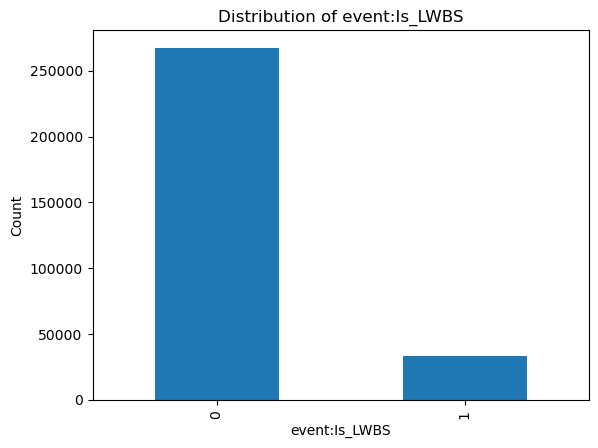

In [8]:
import matplotlib.pyplot as plt

# Plot the counts of each category
category_counts.plot(kind='bar')
plt.xlabel('event:Is_LWBS')
plt.ylabel('Count')
plt.title('Distribution of event:Is_LWBS')
plt.show()


In [9]:
# Define the sequence length
sequence_length = 7

# Define the number of event features and case features

case_feature_columns = ['case:SEX', 'case:VISIT_AGE', 'case:Is_Deceased', 'case:Distance_to_Hospital', 'case:Is_NL_Holiday', 
                        'case:Day_of_Week', 'case:Is_Weekend', 'case:Visit_Frequency', 'case:Prior_LWBS', 'case:First_Imaging_Test_Encoded', 
                        'case:First_Lab_Test_Encoded', 'case:Case_Duration_Hours', 'case:Num_Imaging_Tests', 'case:Num_Lab_Tests', 
                        'case:FACILITY_ID_BUR', 'case:FACILITY_ID_CGH', 'case:FACILITY_ID_GBC', 'case:FACILITY_ID_HSC', 
                        'case:FACILITY_ID_SCM', 'case:TIME_OF_THE_DAY_Ordinal', 'case:Visit_Season_Ordinal']

event_feature_columns = ['event:CTAS', 'event:ED_Business_Hourly', 'event:Acuity_Score', 'event:Activity_Duration', 'event:Disposition_Frequency',
                         'event:Activity_Admitting patient', 'event:Activity_Assessment', 'event:Activity_Making admit decision',
                         'event:Activity_Patient departed', 'event:Activity_Patient discharge', 'event:Activity_Providing service', 
                         'event:Activity_Triage']

# Define the number of event features and case features
num_event_features = len(event_feature_columns)  # number of event features
num_case_features = len(case_feature_columns)  # number of case features


# Sort by VISIT_ID before grouping
df_event_log_dl_sorted = df_event_log_dl.sort_values(by='case:VISIT_ID')
grouped = df_event_log_dl_sorted.groupby('case:VISIT_ID')





In [10]:
# Initialize lists to hold sequences and labels
sequences_event = []
sequences_case = []
sequence_labels = []

# Iterate over each group
for _, group in grouped:
    # Extract case attributes (assuming they are the same for each group)
    case_features = group[case_feature_columns].iloc[0].values
    
    # Drop case attributes and 'VISIT_ID' from event features
    group_features = group[event_feature_columns].astype(float)
    group_labels = group['event:Is_LWBS']
    
    # Padding if necessary
    num_missing = sequence_length - len(group)
    if num_missing > 0:
        # Padding features with zeros at the beginning
        padding = np.zeros((num_missing, group_features.shape[1]))
        group_features = np.vstack((padding, group_features))
        # Padding labels with a neutral value at the beginning
        padded_labels = np.pad(group_labels, (num_missing, 0), 'edge')
    elif num_missing < 0:
        group_features = group_features.iloc[:sequence_length]
        group_labels = group_labels.iloc[:sequence_length]
        padded_labels = group_labels.values
    else:
        padded_labels = group_labels.values
    
    # Add to sequences
    sequences_event.append(group_features)
    sequences_case.append(case_features)
    sequence_labels.append(padded_labels[-1])

# Convert to arrays for further processing
event_features = np.array(sequences_event, dtype=np.float32)
case_features = np.array(sequences_case, dtype=np.float32)
labels = np.array(sequence_labels, dtype=np.float32)


In [11]:
num_event_features

12

In [12]:
# event:CTAS: 3.0 , event:ED_Business_Hourly: 11.0, event:Activity_Duration: 0.0 , 
# event:Disposition_Frequency: 0.71428571, event:Activity_Admitting patient: 0.0, 
# event:Activity_Assessment: 0.0, event:Activity_Making admit decision: 0.0, 
# event:Activity_Patient departed: 0.0, event:Activity_Patient discharge: 0.0, 
# event:Activity_Providing service: 0.0, event:Activity_Triage: 1.0, 

event_features[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 3.        , 11.        ,  0.33333334,  0.        ,  0.71428573,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 3.        , 11.        ,  0.33333334,  0.03333334,  0.71428573,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [ 3.        , 11.        ,  0.33333334,  0.1       ,  0.71428573,
         0.        ,  

In [13]:
num_case_features

21

In [14]:
# case:SEX, case:VISIT_AGE, case:Is_Deceased, case:Distance_to_Hospital, 
# case:Is_NL_Holiday, case:Day_of_Week, case:Is_Weekend, case:Visit_Frequency,
# case:Prior_LWBS, case:First_Imaging_Test_Encoded, case:First_Lab_Test_Encoded,
# case:Case_Duration_Hours, case:Num_Imaging_Tests, case:Num_Lab_Tests, 
# case:FACILITY_ID_BUR, case:FACILITY_ID_CGH, case:FACILITY_ID_GBC,
# case:FACILITY_ID_HSC, case:FACILITY_ID_SCM, case:TIME_OF_THE_DAY_Ordinal, 
# case:Visit_Season_Ordinal

case_features[0]

array([ 1.    , 62.75  ,  0.    , 22.2337,  0.    ,  4.    ,  0.    ,
        4.    ,  0.    , 64.    , 85.    ,  0.55  ,  1.    ,  0.    ,
        0.    ,  1.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
      dtype=float32)

In [15]:
# Training, validation, and testing splits
train_idx = int(.6 * len(event_features))
val_idx = int(.8 * len(event_features))

train_features_event = event_features[:train_idx]
val_features_event = event_features[train_idx:val_idx]
test_features_event = event_features[val_idx:]

train_features_case = case_features[:train_idx]
val_features_case = case_features[train_idx:val_idx]
test_features_case = case_features[val_idx:]

train_labels = labels[:train_idx]
val_labels = labels[train_idx:val_idx]
test_labels = labels[val_idx:]


In [16]:
# Create TensorFlow datasets
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices(((train_features_event, train_features_case), train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(((val_features_event, val_features_case), val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(((test_features_event, test_features_case), test_labels)).batch(32)

In [17]:
def inspect_single_sequence(dataset, num_batches=1):
    # Convert the dataset to a list of numpy arrays for inspection
    dataset_samples = list(dataset.as_numpy_iterator())

    for i in range(min(num_batches, len(dataset_samples))):
        batch_features, batch_labels = dataset_samples[i]

        # Inspect the first sequence in the batch
        inspected_features = batch_features[0]
        inspected_labels = batch_labels[0]

        print(f"Batch {i + 1} - Inspected Features:\n", inspected_features)
        print(f"Batch {i + 1} - Inspected Label:\n", inspected_labels)
        print("\n")

# Inspect sequences from training, validation, and test datasets
print("Training Dataset Inspection:")
inspect_single_sequence(train_dataset)

print("Validation Dataset Inspection:")
inspect_single_sequence(val_dataset)

print("Test Dataset Inspection:")
inspect_single_sequence(test_dataset)


Training Dataset Inspection:
Batch 1 - Inspected Features:
 [[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 3.         11.          0.33333334 ...  0.          1.
    0.        ]
  [ 3.         11.          0.33333334 ...  0.          0.
    0.        ]
  [ 3.         11.          0.33333334 ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 4.          8.          0.25       ...  0.          0.
    0.        ]
  [ 4.         11.          0.25       ...  0.          0.
    1.        ]
  [ 4.         11.          0.25       ...  0.          1.
    0.        ]]

 [[ 0.          0.      

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

# Define input shapes
event_feature_shape = (sequence_length, num_event_features)
case_feature_shape = (num_case_features,)

# Event features input
event_input = Input(shape=event_feature_shape, name='event_input')

# LSTM layers
lstm_out = LSTM(64, return_sequences=False)(event_input)

# Case features input
case_input = Input(shape=case_feature_shape, name='case_input')

# Concatenate case attributes
combined = Concatenate()([lstm_out, case_input])

# Final dense layer for classification
output = Dense(1, activation='sigmoid')(combined)

# Define the model
model_many_to_one = Model(inputs=[event_input, case_input], outputs=output)

# Compile the model
model_many_to_one.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_many_to_one.summary()

# Train the model
history_many_to_one = model_many_to_one.fit(train_dataset, validation_data=val_dataset, epochs=10)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 event_input (InputLayer)    [(None, 7, 12)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 64)                   19712     ['event_input[0][0]']         
                                                                                                  
 case_input (InputLayer)     [(None, 21)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 85)                   0         ['lstm[0][0]',                
                                                                     'case_input[0][0]']      

487/487 [==============================] - 2s 4ms/step


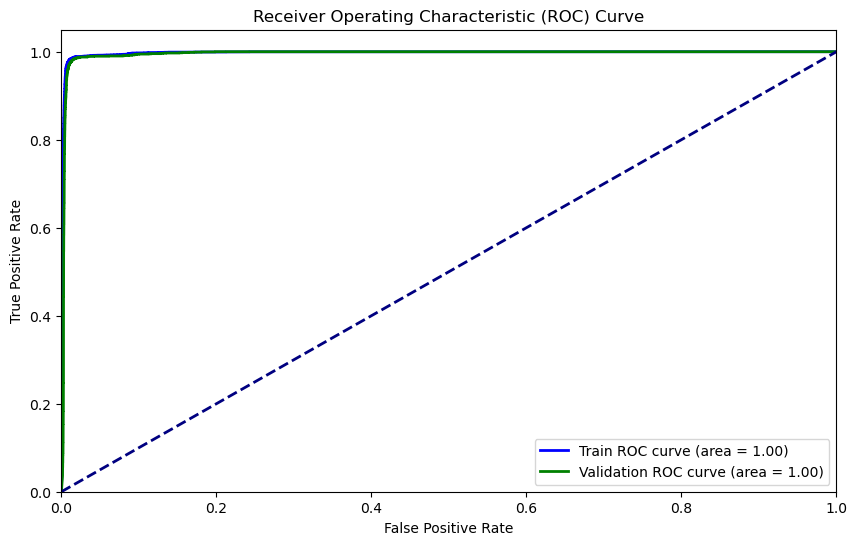

Confusion Matrix for Training Set:
[[39344   458]
 [  112  6802]]
Confusion Matrix for Validation Set:
[[13285   224]
 [   34  2029]]


In [20]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Generate predictions for the training set
train_probs = model_many_to_one.predict([train_features_event, train_features_case]).ravel()
train_labels_flat = train_labels.ravel()  # Flatten the labels

# Generate predictions for the validation set
val_probs = model_many_to_one.predict([val_features_event, val_features_case]).ravel()
val_labels_flat = val_labels.ravel()  # Flatten the labels

# Compute ROC curve and AUC for the training set
fpr_train, tpr_train, _ = roc_curve(train_labels_flat, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for the validation set
fpr_val, tpr_val, _ = roc_curve(val_labels_flat, val_probs)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curves
plt.figure(figsize=(10, 6))

# ROC curve for training set
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

# ROC curve for validation set
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show plot
plt.show()

# Convert probabilities to binary predictions based on a threshold of 0.5
train_preds = (train_probs > 0.5).astype(int)
val_preds = (val_probs > 0.5).astype(int)

# Compute confusion matrix for training set
cm_train = confusion_matrix(train_labels_flat, train_preds)
print("Confusion Matrix for Training Set:")
print(cm_train)

# Compute confusion matrix for validation set
cm_val = confusion_matrix(val_labels_flat, val_preds)
print("Confusion Matrix for Validation Set:")
print(cm_val)

# true positives, true negatives, false positives, and false negatives.


In [21]:
# Confusion Matrix for Training Set
cm_train = np.array([[39409, 393], [124, 6790]])

# True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
TP_train = cm_train[1, 1]
TN_train = cm_train[0, 0]
FP_train = cm_train[0, 1]
FN_train = cm_train[1, 0]

# Calculate accuracy for the training set
accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train)
print(f"Training Set Accuracy: {accuracy_train:.4f}")

# Confusion Matrix for Validation Set
cm_val = np.array([[13320, 189], [38, 2025]])

# True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
TP_val = cm_val[1, 1]
TN_val = cm_val[0, 0]
FP_val = cm_val[0, 1]
FN_val = cm_val[1, 0]

# Calculate accuracy for the validation set
accuracy_val = (TP_val + TN_val) / (TP_val + TN_val + FP_val + FN_val)
print(f"Validation Set Accuracy: {accuracy_val:.4f}")


Training Set Accuracy: 0.9889
Validation Set Accuracy: 0.9854


In [22]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_many_to_one.history['accuracy'], label='Train Accuracy')
plt.plot(history_many_to_one.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_many_to_one.history['loss'], label='Train Loss')
plt.plot(history_many_to_one.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


487/487 [==============================] - 3s 4ms/step
Confusion Matrix:
 [[13177   305]
 [   24  2066]]


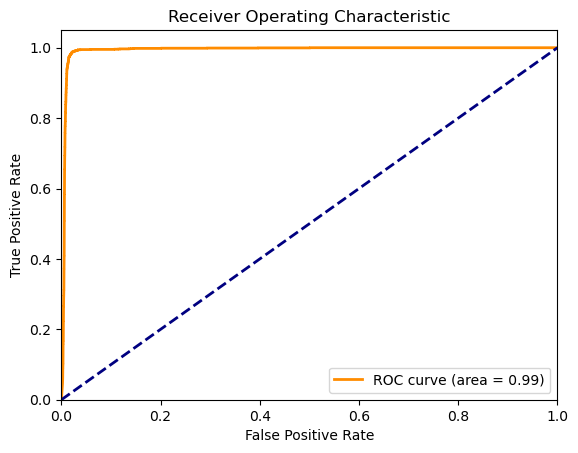

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Generate predictions
y_pred = model_many_to_one.predict(test_dataset).ravel()  # Flatten the predictions

# Converting probabilities to binary output based on a threshold
y_pred_bin = (y_pred > 0.5).astype('int')

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred_bin)
print("Confusion Matrix:\n", cm)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# true positives, true negatives, false positives, and false negatives.

In [24]:
test_loss, test_accuracy = model_many_to_one.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


487/487 [==============================] - 2s 4ms/step - loss: 0.1373 - accuracy: 0.9789
Test Loss: 0.13729514181613922
Test Accuracy: 0.9788723587989807


# Looking at the Last Step

## Advantages:

Simplifies the interpretation by focusing on the final part of the sequence that directly contributes to the prediction.
Easier to understand and visualize.
Often sufficient if the final prediction is more influenced by the most recent information.

## Disadvantages:

Might miss important information from earlier time steps that contributed to the prediction.

In [25]:
# Ensure num_event_features is defined
num_event_features = len(event_feature_columns)

# Extract the last step event features from the test set
last_step_event_features = test_features_event[:, -1, :]

# Combine the last step event features with case features
X_test_combined_last_step = np.hstack([last_step_event_features, test_features_case])

# Create meaningful feature names for the last step
last_step_event_feature_names = [f'{feature}_t{sequence_length}' for feature in event_feature_columns]

# Combine with case feature names
combined_feature_names_last_step = last_step_event_feature_names + case_feature_columns


In [26]:
# Define a prediction function for LIME focusing on the last step
def predict_fn_last_step(data):
    # The input data contains both last step event features and case features
    num_samples = data.shape[0]
    
    # Split the data into last step event features and case features
    last_step_event_features = data[:, :num_event_features]
    case_features = data[:, num_event_features:]
    
    # Expand the last step event features to match the expected sequence length
    expanded_event_features = np.zeros((num_samples, sequence_length, num_event_features))
    expanded_event_features[:, -1, :] = last_step_event_features  # place the last step features at the last position
    
    # Make predictions using the trained model
    positive_class_probs = model_many_to_one.predict([expanded_event_features, case_features])
    
    # Convert single probability to two probabilities (positive and negative class)
    negative_class_probs = 1 - positive_class_probs
    return np.hstack((negative_class_probs, positive_class_probs))


In [27]:
import lime
from lime import lime_tabular

# Create a LIME explainer with feature names focused on the last step
explainer_last_step = lime_tabular.LimeTabularExplainer(
    X_test_combined_last_step, 
    feature_names=combined_feature_names_last_step,
    class_names=['Not_LWBS', 'LWBS'],
    mode='classification'
)

# Select a sample from the test set
sample_idx = 0  # Index of the sample to explain
sample_last_step_event = last_step_event_features[sample_idx]
sample_case = test_features_case[sample_idx]
sample_last_step = np.concatenate((sample_last_step_event, sample_case))

# Explain the selected sample
exp_last_step = explainer_last_step.explain_instance(sample_last_step, predict_fn_last_step)

# Show the explanation
exp_last_step.show_in_notebook(show_all=False)


157/157 [==============================] - 1s 4ms/step


# Looking at Each Step

## Advantages:

Provides a detailed understanding of how the model's predictions evolve over time and helps identify which features are influential at different time steps.

## Disadvantages:
Can be more complex to interpret, especially with many time steps and features.
whelming.

In [28]:
# Define a prediction function for LIME
def predict_fn(data):
    # Convert data to the right format (e.g., if necessary, add the case features)
    event_features = data[:, :num_event_features * sequence_length].reshape((-1, sequence_length, num_event_features))
    case_features = data[:, num_event_features * sequence_length:]
    
    # Make predictions using the trained model
    positive_class_probs = model_many_to_one.predict([event_features, case_features])
    
    # Convert single probability to two probabilities (positive and negative class)
    negative_class_probs = 1 - positive_class_probs
    return np.hstack((negative_class_probs, positive_class_probs))

In [29]:
# Create event feature names for each time step
event_feature_names = []
for t in range(sequence_length):
    for feature in event_feature_columns:
        event_feature_names.append(f'{feature}_t{t+1}')


In [30]:
# Combine event feature names and case feature names
combined_feature_names = event_feature_names + case_feature_columns
combined_feature_names

['event:CTAS_t1',
 'event:ED_Business_Hourly_t1',
 'event:Acuity_Score_t1',
 'event:Activity_Duration_t1',
 'event:Disposition_Frequency_t1',
 'event:Activity_Admitting patient_t1',
 'event:Activity_Assessment_t1',
 'event:Activity_Making admit decision_t1',
 'event:Activity_Patient departed_t1',
 'event:Activity_Patient discharge_t1',
 'event:Activity_Providing service_t1',
 'event:Activity_Triage_t1',
 'event:CTAS_t2',
 'event:ED_Business_Hourly_t2',
 'event:Acuity_Score_t2',
 'event:Activity_Duration_t2',
 'event:Disposition_Frequency_t2',
 'event:Activity_Admitting patient_t2',
 'event:Activity_Assessment_t2',
 'event:Activity_Making admit decision_t2',
 'event:Activity_Patient departed_t2',
 'event:Activity_Patient discharge_t2',
 'event:Activity_Providing service_t2',
 'event:Activity_Triage_t2',
 'event:CTAS_t3',
 'event:ED_Business_Hourly_t3',
 'event:Acuity_Score_t3',
 'event:Activity_Duration_t3',
 'event:Disposition_Frequency_t3',
 'event:Activity_Admitting patient_t3',
 'ev

In [31]:

import lime
from lime import lime_tabular 

# Combine all test data for LIME
X_test_combined = np.hstack([test_features_event.reshape((test_features_event.shape[0], -1)), test_features_case])

# Create meaningful feature names
event_feature_names = []
for t in range(sequence_length):
    for feature in event_feature_columns:
        event_feature_names.append(f'{feature}_t{t+1}')

# Combine event feature names and case feature names
combined_feature_names = event_feature_names + case_feature_columns

# Create a LIME explainer with meaningful feature names
explainer = lime_tabular.LimeTabularExplainer(
    X_test_combined, 
    feature_names=combined_feature_names,
    class_names=['Not_LWBS', 'LWBS'],
    mode='classification'
)

# Select a sample from the test set
sample_idx = 0  # Index of the sample to explain
sample_event = test_features_event[sample_idx].flatten()
sample_case = test_features_case[sample_idx]
sample = np.concatenate((sample_event, sample_case))

# Explain the selected sample
exp = explainer.explain_instance(sample, predict_fn)

# Show the explanation
exp.show_in_notebook(show_all=False)


157/157 [==============================] - 1s 4ms/step


# Addressing the Class Imbalance

DEPART_DISPOSITION_ID
- D: 245904
- TLWBS: 3248
- 4: 168
- ADM: 61
- TTO: 3027
- ITLBC: 878
- RLWBS: 770
- AMA: 347
- TA: 152
- EXP: 127
- ALBT: 111
- DS: 47
- TC: 45
- TL:
   14
- TCC: 11
t, dtype: int64

In [32]:
# Calculate class distribution
class_counts = np.array([245904, 3248, 168, 61, 3027, 878, 770, 347, 152, 127, 111, 47, 45, 14, 11])
lwbs_counts = class_counts[1] + class_counts[6]
total_counts = np.sum(class_counts)

print(f"Total instances: {total_counts}")
print(f"LWBS instances: {lwbs_counts}")
print(f"Non-LWBS instances: {total_counts - lwbs_counts}")
print(f"LWBS proportion: {lwbs_counts / total_counts:.4f}")


Total instances: 254910
LWBS instances: 4018
Non-LWBS instances: 250892
LWBS proportion: 0.0158


In [33]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Check original class distribution
original_class_distribution = Counter(train_labels)
print("Original class distribution:", original_class_distribution)


Original class distribution: Counter({0.0: 39802, 1.0: 6914})


In [34]:

# Define sampling strategy
# sampling_strategy = 0.5  balance classes to 50% of the majority class
sampling_strategy = 'auto'

# Create resampling pipeline
pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy=sampling_strategy)),
    ('under', RandomUnderSampler(sampling_strategy=sampling_strategy))
])

# Flatten event features for resampling
train_features_combined = np.hstack([train_features_event.reshape(train_features_event.shape[0], -1), train_features_case])

# Resample the training data
train_features_resampled, train_labels_resampled = pipeline.fit_resample(train_features_combined, train_labels)

# Separate the resampled features back into event and case features
num_samples = train_features_resampled.shape[0]
train_features_event_resampled = train_features_resampled[:, :num_event_features * sequence_length].reshape(num_samples, sequence_length, num_event_features)
train_features_case_resampled = train_features_resampled[:, num_event_features * sequence_length:]


In [35]:
# Check resampled class distribution
resampled_class_distribution = Counter(train_labels_resampled)
print("Resampled class distribution:", resampled_class_distribution)

# Calculate number of new rows added
original_total = sum(original_class_distribution.values())
resampled_total = sum(resampled_class_distribution.values())
new_rows_added = resampled_total - original_total

print("Number of new rows added:", new_rows_added)

Resampled class distribution: Counter({0.0: 39802, 1.0: 39802})
Number of new rows added: 32888


In [36]:
train_features_event_resampled[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 3.        , 11.        ,  0.33333334,  0.        ,  0.71428573,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ],
       [ 3.        , 11.        ,  0.33333334,  0.03333334,  0.71428573,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ],
       [ 3.        , 11.        ,  0.33333334,  0.1       ,  0.71428573,
         0.        ,  

In [37]:
train_features_case_resampled[0]

array([ 1.    , 62.75  ,  0.    , 22.2337,  0.    ,  4.    ,  0.    ,
        4.    ,  0.    , 64.    , 85.    ,  0.55  ,  1.    ,  0.    ,
        0.    ,  1.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
      dtype=float32)

In [38]:
# Create TensorFlow dataset with both event and case features
train_dataset_resampled = tf.data.Dataset.from_tensor_slices(((train_features_event_resampled, train_features_case_resampled), train_labels_resampled)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(((val_features_event, val_features_case), val_labels)).batch(32)


In [39]:
# Define input shapes
event_feature_shape = (sequence_length, num_event_features)
case_feature_shape = (num_case_features,)

# Event features input
event_input = Input(shape=event_feature_shape, name='event_input')

# LSTM layers
lstm_out = LSTM(64, return_sequences=False)(event_input)

# Case features input
case_input = Input(shape=case_feature_shape, name='case_input')

# Concatenate case attributes
combined = Concatenate()([lstm_out, case_input])

# Final dense layer for classification
output = Dense(1, activation='sigmoid')(combined)

# Define the model
model_many_to_one = Model(inputs=[event_input, case_input], outputs=output)

# Compile the model
model_many_to_one.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_many_to_one.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 event_input (InputLayer)    [(None, 7, 12)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 64)                   19712     ['event_input[0][0]']         
                                                                                                  
 case_input (InputLayer)     [(None, 21)]                 0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 85)                   0         ['lstm_1[0][0]',              
 )                                                                   'case_input[0][0]']    

In [40]:
# Train the model with resampled data
history_many_to_one_resampled = model_many_to_one.fit(train_dataset_resampled, validation_data=val_dataset, epochs=10)

Epoch 1/10
2488/2488 [==============================] - 25s 9ms/step - loss: 0.5632 - accuracy: 0.9859 - val_loss: 20.7519 - val_accuracy: 0.1356
Epoch 2/10
2488/2488 [==============================] - 21s 8ms/step - loss: 0.3491 - accuracy: 0.9782 - val_loss: 17.2370 - val_accuracy: 0.1351
Epoch 3/10
2488/2488 [==============================] - 22s 9ms/step - loss: 0.2163 - accuracy: 0.9841 - val_loss: 15.2782 - val_accuracy: 0.1372
Epoch 4/10
2488/2488 [==============================] - 22s 9ms/step - loss: 0.1524 - accuracy: 0.9878 - val_loss: 14.9294 - val_accuracy: 0.1386
Epoch 5/10
2488/2488 [==============================] - 21s 8ms/step - loss: 0.1302 - accuracy: 0.9891 - val_loss: 14.6387 - val_accuracy: 0.1410
Epoch 6/10
2488/2488 [==============================] - 21s 9ms/step - loss: 0.1101 - accuracy: 0.9898 - val_loss: 14.1840 - val_accuracy: 0.1449
Epoch 7/10
2488/2488 [==============================] - 21s 8ms/step - loss: 0.1043 - accuracy: 0.9900 - val_loss: 14.3956 -

487/487 [==============================] - 2s 4ms/step


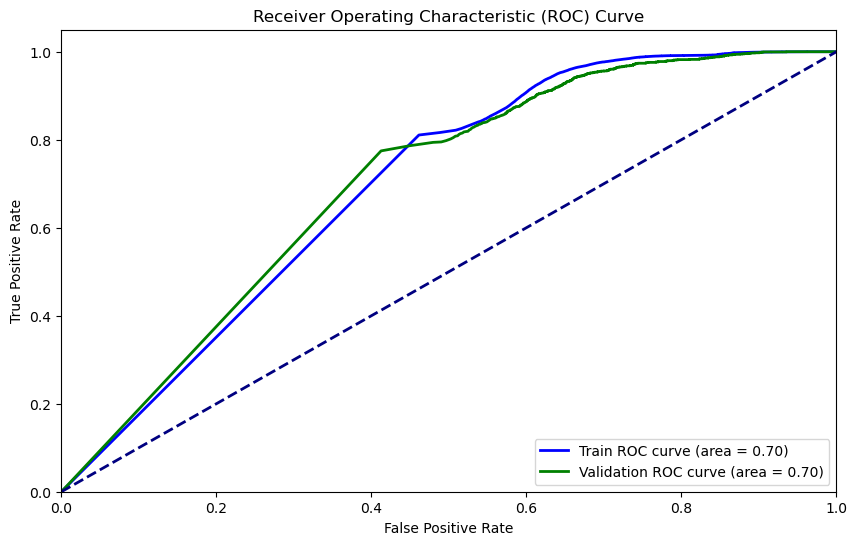

Confusion Matrix for Training Set:
[[ 1070 38732]
 [    0 39802]]
Confusion Matrix for Validation Set:
[[  439 13070]
 [    0  2063]]


In [41]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Generate predictions for the resampled training set
train_probs_resampled = model_many_to_one.predict([train_features_event_resampled, train_features_case_resampled]).ravel()
train_labels_resampled_flat = train_labels_resampled.ravel()  # Flatten the labels

# Generate predictions for the validation set
val_probs = model_many_to_one.predict([val_features_event, val_features_case]).ravel()
val_labels_flat = val_labels.ravel()  # Flatten the labels

# Compute ROC curve and AUC for the training set
fpr_train, tpr_train, _ = roc_curve(train_labels_resampled_flat, train_probs_resampled)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for the validation set
fpr_val, tpr_val, _ = roc_curve(val_labels_flat, val_probs)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curves
plt.figure(figsize=(10, 6))

# ROC curve for training set
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

# ROC curve for validation set
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show plot
plt.show()

# Convert probabilities to binary predictions based on a threshold of 0.5
train_preds_resampled = (train_probs_resampled > 0.5).astype(int)
val_preds = (val_probs > 0.5).astype(int)

# Compute confusion matrix for training set
cm_train_resampled = confusion_matrix(train_labels_resampled_flat, train_preds_resampled)
print("Confusion Matrix for Training Set:")
print(cm_train_resampled)

# Compute confusion matrix for validation set
cm_val = confusion_matrix(val_labels_flat, val_preds)
print("Confusion Matrix for Validation Set:")
print(cm_val)



487/487 [==============================] - 2s 4ms/step


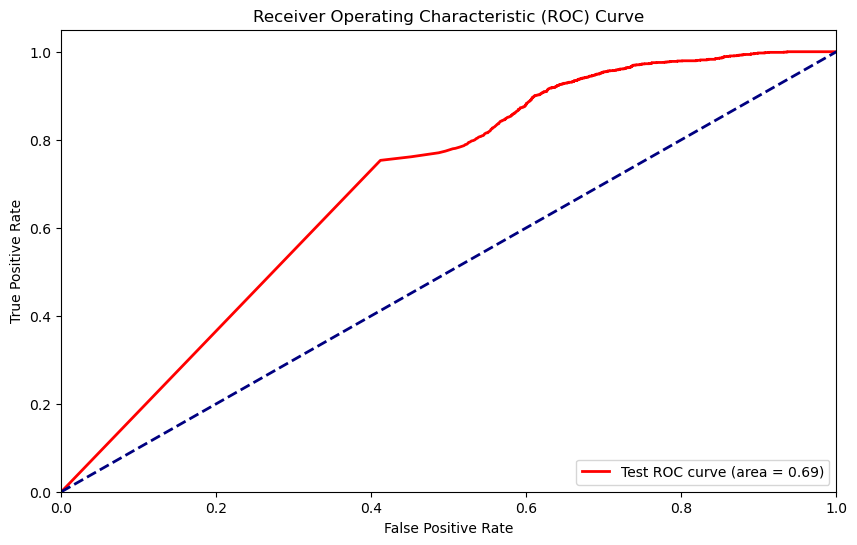

Confusion Matrix for Test Set:
[[  439 13043]
 [    0  2090]]


In [42]:

# Create TensorFlow dataset for the test data
test_dataset = tf.data.Dataset.from_tensor_slices(((test_features_event, test_features_case), test_labels)).batch(32)

# Generate predictions for the test set
test_probs = model_many_to_one.predict([test_features_event, test_features_case]).ravel()
test_labels_flat = test_labels.ravel()  # Flatten the labels

# Compute ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(test_labels_flat, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(10, 6))

# ROC curve for test set
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show plot
plt.show()

# Convert probabilities to binary predictions based on a threshold of 0.5
test_preds = (test_probs > 0.5).astype(int)

# Compute confusion matrix for test set
cm_test = confusion_matrix(test_labels_flat, test_preds)
print("Confusion Matrix for Test Set:")
print(cm_test)




In [43]:
test_loss, test_accuracy = model_many_to_one.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

487/487 [==============================] - 3s 5ms/step - loss: 12.8063 - accuracy: 0.1624
Test Loss: 12.80633544921875
Test Accuracy: 0.16240689158439636


## Trying to enhance the model's performance

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define input shapes
event_feature_shape = (sequence_length, num_event_features)
case_feature_shape = (num_case_features,)

# Event features input
event_input = Input(shape=event_feature_shape, name='event_input')

# LSTM layers with dropout and L2 regularization
lstm_out = LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))(event_input)
lstm_out = Dropout(0.5)(lstm_out)  # Adding dropout

# Case features input
case_input = Input(shape=case_feature_shape, name='case_input')

# Concatenate case attributes
combined = Concatenate()([lstm_out, case_input])

# Final dense layer for classification with L2 regularization
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(combined)

# Define the model
model_with_regularization = Model(inputs=[event_input, case_input], outputs=output)
class_weights = {0: 1.0, 1: 10.0} 

model_with_regularization.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_with_regularization.summary()

# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and class weights
history_with_regularization = model_with_regularization.fit(
    train_dataset_resampled, 
    validation_data=val_dataset, 
    epochs=50,  
     class_weight=class_weights,
    callbacks=[early_stopping]
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 event_input (InputLayer)    [(None, 7, 12)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 64)                   19712     ['event_input[0][0]']         
                                                                                                  
 dropout (Dropout)           (None, 64)                   0         ['lstm_2[0][0]']              
                                                                                                  
 case_input (InputLayer)     [(None, 21)]                 0         []                            
                                                                                            

487/487 [==============================] - 3s 4ms/step


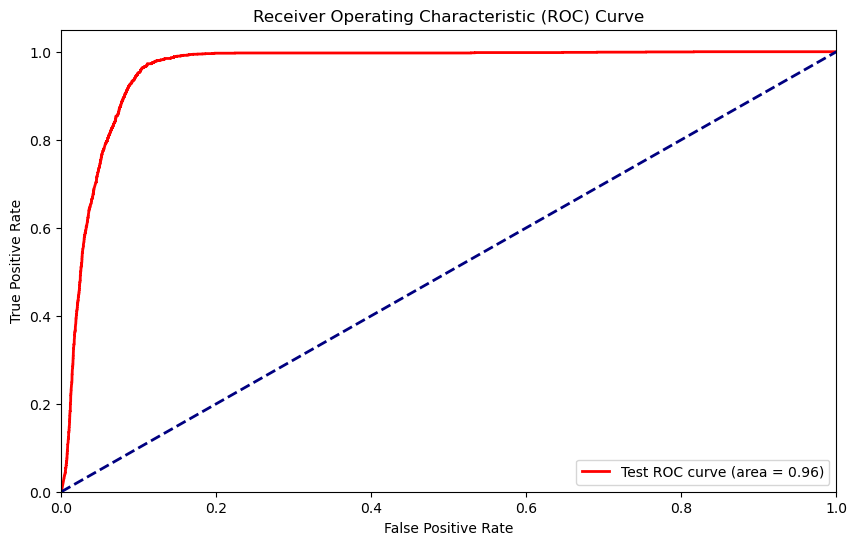

Confusion Matrix for Test Set:
[[ 1528 11954]
 [    0  2090]]


In [45]:
# Generate predictions for the test set
test_probs = model_with_regularization.predict([test_features_event, test_features_case]).ravel()
test_labels_flat = test_labels.ravel()  # Flatten the labels

# Compute ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(test_labels_flat, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Convert probabilities to binary predictions based on a threshold of 0.5
test_preds = (test_probs > 0.5).astype(int)

# Compute confusion matrix for test set
cm_test = confusion_matrix(test_labels_flat, test_preds)
print("Confusion Matrix for Test Set:")
print(cm_test)




In [46]:
test_loss, test_accuracy = model_with_regularization.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

487/487 [==============================] - 2s 4ms/step - loss: 2.6559 - accuracy: 0.2323
Test Loss: 2.6559207439422607
Test Accuracy: 0.23234009742736816


In [47]:
# Combine the last step event features with case features
X_test_combined_last_step = np.hstack([last_step_event_features, test_features_case])

# Create meaningful feature names for the last step
last_step_event_feature_names = [f'{feature}_t{sequence_length}' for feature in event_feature_columns]

# Combine with case feature names
combined_feature_names_last_step = last_step_event_feature_names + case_feature_columns

# Create a LIME explainer with feature names focused on the last step
explainer_last_step = lime_tabular.LimeTabularExplainer(
    X_test_combined_last_step, 
    feature_names=combined_feature_names_last_step,
    class_names=['Not_LWBS', 'LWBS'],
    mode='classification'
)

# Select a sample from the test set
sample_idx = 0  # Index of the sample to explain
sample_last_step_event = last_step_event_features[sample_idx]
sample_case = test_features_case[sample_idx]
sample_last_step = np.concatenate((sample_last_step_event, sample_case))




In [48]:
# Define a prediction function for LIME focusing on the last step
def predict_fn_last_step(data):
    # The input data contains both last step event features and case features
    num_samples = data.shape[0]
    
    # Split the data into last step event features and case features
    last_step_event_features = data[:, :num_event_features]
    case_features = data[:, num_event_features:]
    
    # Reshape the last step event features to match the model's input shape
    last_step_event_features = last_step_event_features.reshape((num_samples, 1, num_event_features))
    
    # Make predictions using the trained model
    positive_class_probs = model_with_regularization.predict([last_step_event_features, case_features])
    
    # Convert single probability to two probabilities (positive and negative class)
    negative_class_probs = 1 - positive_class_probs
    return np.hstack((negative_class_probs, positive_class_probs))

In [49]:
# Explain the selected sample
exp_last_step = explainer_last_step.explain_instance(sample_last_step, predict_fn_last_step)

# Show the explanation
exp_last_step.show_in_notebook(show_all=False) 

157/157 [==============================] - 1s 3ms/step
